In [ ]:
import base64
import configparser
import io
import json
from datetime import datetime

import IPython.display
import redis
from matplotlib.pyplot import imshow
from PIL import Image

import utils
from pony.orm import *

In [19]:
set_sql_debug(True)

In [20]:
config = configparser.ConfigParser()
config.read("config.ini")


['config.ini']

In [21]:
provider = "mysql"


In [53]:
db = Database()

db.bind(
    provider=provider,
    host=config[provider]["host"],
    user=config[provider]["user"],
    passwd=config[provider]["pass"],
    db="media_index4",
)


GET NEW CONNECTION
RELEASE CONNECTION


In [54]:
try:
    db.drop_table("thumbnail")
except TableDoesNotExist:
    pass
except:
    raise


GET CONNECTION FROM THE LOCAL POOL
SET foreign_key_checks = 0
DROPPING TABLE `thumbnail`
COMMIT
SET foreign_key_checks = 1
CLOSE CONNECTION


In [55]:
class Thumbnail(db.Entity):
    id = PrimaryKey(int, auto=True)
    xxhash = Required(str, unique=True)
    thumbnail = Optional(buffer)


db.generate_mapping(create_tables=True)


GET NEW CONNECTION
SET foreign_key_checks = 0
CREATE TABLE `thumbnail` (
  `id` INTEGER PRIMARY KEY AUTO_INCREMENT,
  `xxhash` VARCHAR(255) UNIQUE NOT NULL,
  `thumbnail` LONGBLOB
)

SELECT `thumbnail`.`id`, `thumbnail`.`xxhash`, `thumbnail`.`thumbnail`
FROM `thumbnail` `thumbnail`
WHERE 0 = 1

COMMIT
SET foreign_key_checks = 1
CLOSE CONNECTION


In [56]:
config = configparser.ConfigParser()
config.read("config.ini")
exif_cache = redis.StrictRedis(
    host=config["redis"]["host"],
    port=config["redis"]["port"],
    db=config["redis"]["exif"],
)
xxhash_cache = redis.StrictRedis(
    host=config["redis"]["host"],
    port=config["redis"]["port"],
    db=config["redis"]["xxhash"],
)


In [58]:
utils.cache_exif("/projects/darknet/data/dog.jpg")


Cached hash : /projects/darknet/data/dog.jpg
Cached EXIF : /projects/darknet/data/dog.jpg


{'SourceFile': '/projects/darknet/data/dog.jpg',
 'ExifTool:ExifToolVersion': 10.8,
 'File:FileName': 'dog.jpg',
 'File:Directory': '/projects/darknet/data',
 'File:FileSize': 163759,
 'File:FileModifyDate': '2018:08:22 21:08:09-04:00',
 'File:FileAccessDate': '2018:08:25 17:35:14-04:00',
 'File:FileInodeChangeDate': '2018:08:22 21:08:09-04:00',
 'File:FilePermissions': 664,
 'File:FileType': 'JPEG',
 'File:FileTypeExtension': 'JPG',
 'File:MIMEType': 'image/jpeg',
 'File:ExifByteOrder': 'MM',
 'File:CurrentIPTCDigest': 'ea77cae62a2f464e96d52a5ed9b14692',
 'File:ImageWidth': 768,
 'File:ImageHeight': 576,
 'File:EncodingProcess': 0,
 'File:BitsPerSample': 8,
 'File:ColorComponents': 3,
 'File:YCbCrSubSampling': '1 2',
 'EXIF:ImageDescription': '                               ',
 'EXIF:Make': 'Canon',
 'EXIF:Model': 'Canon PowerShot S95',
 'EXIF:Orientation': 1,
 'EXIF:XResolution': 72,
 'EXIF:YResolution': 72,
 'EXIF:ResolutionUnit': 2,
 'EXIF:Software': 'Photos 1.0',
 'EXIF:ModifyDate

In [59]:
key = "/projects/darknet/data/dog.jpg".encode("UTF-8")
key


b'/projects/darknet/data/dog.jpg'

In [60]:
size = (255, 255)


In [61]:
path = key.decode()
xxhash = xxhash_cache.get(key).decode()
xxhash


'7a4ee943299372fb'

In [63]:
img = Image.open(path)
img.thumbnail(size)


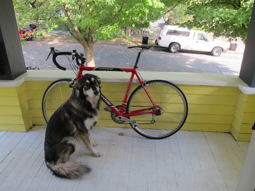

In [64]:
img


In [43]:
with io.BytesIO() as output:
    img.save(output, format="jpeg")
    contents = output.getvalue()


In [44]:
contents


b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\xbf\x00\xff\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\

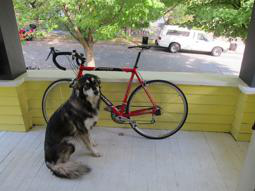

In [66]:
Image.open(io.BytesIO(contents))


In [49]:
with io.BytesIO

In [51]:
output.write(contents)


10795

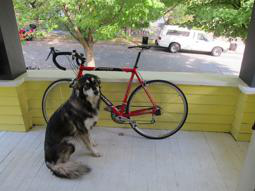

In [52]:
Image.open(output)


In [123]:
np_img_ = np_img.tobytes()


In [124]:
x = Thumbnail(
    xxhash=xxhash, thumbnail=np_img_, height=height, width=width, depth=depth
)


In [134]:
X = Thumbnail.select()


In [136]:
for x_ in X:
    break
x_


SELECT DISTINCT `t-1`.`id`, `t-1`.`xxhash`, `t-1`.`thumbnail`, `t-1`.`height`, `t-1`.`width`, `t-1`.`depth`
FROM `thumbnail` `t-1`



Thumbnail[1]

In [164]:
x__ = np.frombuffer(x_.thumbnail, dtype=np.uint8).reshape(
    x_.height, x_.width, x_.depth
)


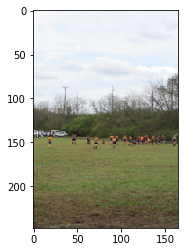

In [165]:
imshow(x__)


In [161]:
np.frombuffer(np_img_, dtype=np.uint8).shape


(122760,)

In [170]:
bytes(img)


TypeError: cannot convert 'JpegImageFile' object to bytes

In [175]:
Image.frombytes(np_img_)


TypeError: frombytes() missing 2 required positional arguments: 'size' and 'data'

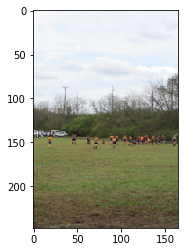

In [125]:
imshow(im)